In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
train = pd.read_csv('D:/Product/Proj/Kaggle/Toxic Comment Classification Challenge/train.csv/train.csv')
test = pd.read_csv('D:/Product/Proj/Kaggle/Toxic Comment Classification Challenge/test.csv/test.csv')
subm = pd.read_csv('D:/Product/Proj/Kaggle/Toxic Comment Classification Challenge/sample_submission.csv/sample_submission.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
lens = train.comment_text.str.len()
lens.mean(),lens.std(),lens.max()
lens

0          264
1          112
2          233
3          622
4           67
5           67
6           44
7          115
8          472
9           70
10        2883
11          56
12         319
13         819
14         219
15         610
16          57
17          48
18         118
19         440
20         266
21          58
22         543
23          97
24        1409
25         172
26         288
27         343
28         119
29          78
          ... 
159541     346
159542     164
159543      80
159544      19
159545     105
159546     534
159547      33
159548      27
159549      25
159550     173
159551     196
159552      92
159553     888
159554     182
159555     119
159556      57
159557     429
159558     134
159559     357
159560    1889
159561    1147
159562    1017
159563     394
159564     369
159565     655
159566     295
159567      99
159568      81
159569     116
159570     189
Name: comment_text, Length: 159571, dtype: int64

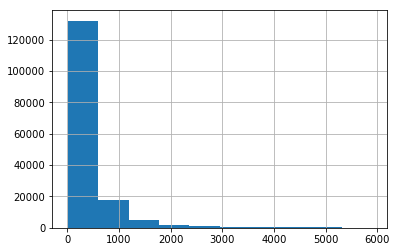

In [6]:
%matplotlib inline
lens.hist()

In [7]:
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train['none'] = 1 - train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
len(train),len(test)

(159571, 153164)

In [9]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown",inplace=True)
test[COMMENT].fillna("unknown",inplace=True)

In [10]:
import re,string
re_tok = re.compile('([' + string.punctuation + '“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ',s).split()

In [11]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2),tokenizer=tokenize,
                      min_df=3,max_df=0.9,strip_accents='unicode',use_idf=1,
                      smooth_idf=1,sublinear_tf=1)
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [12]:
trn_term_doc,test_term_doc

(<159571x425935 sparse matrix of type '<type 'numpy.float64'>'
 	with 17760390 stored elements in Compressed Sparse Row format>,
 <153164x425935 sparse matrix of type '<type 'numpy.float64'>'
 	with 14752585 stored elements in Compressed Sparse Row format>)

In [17]:
def pr(y_i,y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [18]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [19]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y)/pr(0,y))
    m = LogisticRegression(C=4,dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb,y),r

In [20]:
preds = np.zeros((len(test),len(label_cols)))

for i,j in enumerate(label_cols):
    print 'fit',j
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [21]:
submid = pd.DataFrame({'id':subm["id"]})
submission = pd.concat([submid,pd.DataFrame(preds,columns=label_cols)],axis=1)
submission.to_csv('D:/Product/Proj/Kaggle/Toxic Comment Classification Challenge/submission.csv',index=False)